In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
import mglearn
from sklearnex  import  patch_sklearn 
patch_sklearn ()

data_dir = "../Dataset"


def get_data(data_dir: str) -> pd.DataFrame:
    data = pd.DataFrame()
    #data['Trafico'] = 2
    for path in os.listdir(data_dir):    #para cada archivo de la carpeta        
        dir_content = os.path.join(data_dir, path)   #unir cada nombre del archivo al directorio
        if os.path.isfile(dir_content):   #compruebo si es archivo (nombre de ruta absoluto)
            directory = pd.read_csv(dir_content)
            #if path == "Normal_data.csv":
                #directory['Trafico']= 0
            #else:
            #    directory['Trafico']= 1
            
        data = pd.concat([data, directory], ignore_index = True)                
    return data


dataset = get_data(data_dir)

#dataset.to_csv('dataset.csv')
#dataset

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Text(0.5, 1.0, 'Correlación positiva superior al 0.95')

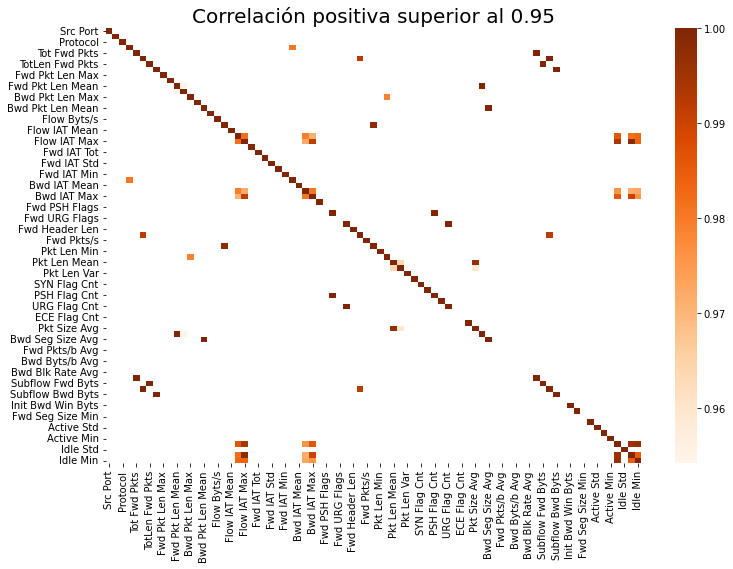

In [2]:
import seaborn as sns

corr = dataset.corr()
kot = corr[corr>=0.95]
#kot.to_csv('correlacion.csv')
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Oranges").set_title('Correlación positiva superior al 0.95', fontsize=20)

Text(0.5, 1.0, 'Correlación negativa inferior al -0.2')

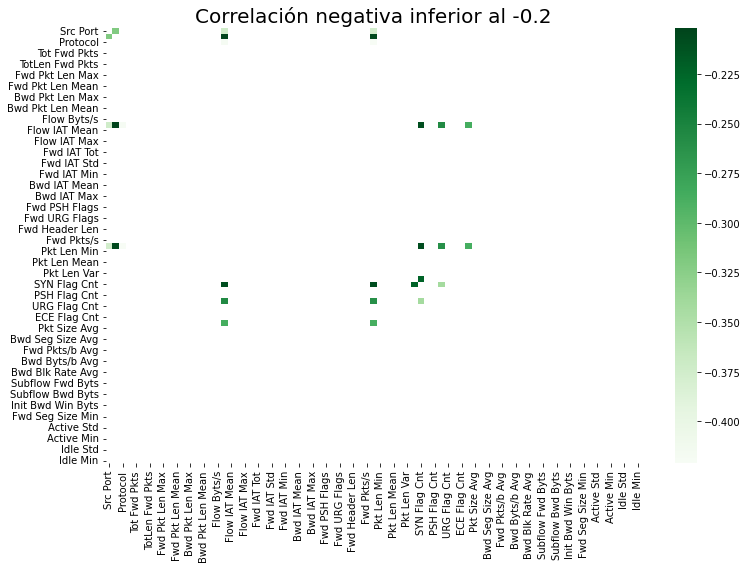

In [3]:
corr = dataset.corr()
kot = corr[corr<=-0.2]
kot.to_csv('correlacion_negativa.csv')
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens").set_title('Correlación negativa inferior al -0.2', fontsize=20)

In [3]:
dataset = dataset.drop(['Flow ID', 'Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Init Fwd Win Byts', 'Fwd Seg Size Min', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Pkt Size Avg', 'PSH Flag Cnt', 'URG Flag Cnt', 'Label'], axis=1)
dataset = dataset.drop([170893, 170896, 170897, 170898, 170899, 170902, 170903, 170906], axis=0)
#dataset.to_csv('dataset_limpio.csv')

In [4]:
dataset['Src-192.168.3.'] = np.where(dataset['Src IP'].str.startswith('192.168.3.'), 1,0)
dataset['Src-192.168.20.'] = np.where(dataset['Src IP'].str.startswith('192.168.20.'), 1,0)
dataset['Src-192.168.8.'] = np.where(dataset['Src IP'].str.startswith('192.168.8.'), 1,0)
dataset['Src-172.17.0.'] = np.where(dataset['Src IP'].str.startswith('172.17.0.'), 1,0)
dataset['Src-200.175.2.0'] = np.where(dataset['Src IP'].str.startswith('200.175.2.0.'), 1,0)

dataset['Dst-192.168.3.'] = np.where(dataset['Dst IP'].str.startswith('192.168.3.'), 1,0)
dataset['Dst-192.168.20.'] = np.where(dataset['Dst IP'].str.startswith('192.168.20.'), 1,0)
dataset['Dst-192.168.8.'] = np.where(dataset['Dst IP'].str.startswith('192.168.8.'), 1,0)
dataset['Dst-172.17.0.'] = np.where(dataset['Dst IP'].str.startswith('172.17.0.'), 1,0)
dataset['Dst-200.175.2.0'] = np.where(dataset['Dst IP'].str.startswith('200.175.2.0.'), 1,0)

dataset['Src_Port 0-1023'] = np.where(dataset['Src Port'] < 1024, 1,0)
dataset['Src_Port 1024-49151'] = np.where((dataset['Src Port'] >= 1024) & (dataset['Src Port'] < 49152), 1,0)
dataset['Src_Port 49152-65535'] = np.where(dataset['Src Port'] >= 49152, 1,0)

dataset['Dst_Port_0-1023'] = np.where(dataset['Dst Port'] < 1024, 1,0)
dataset['Dst_Port_1024-49151'] = np.where((dataset['Dst Port'] >= 1024) & (dataset['Dst Port'] < 49152), 1,0)
dataset['Dst_Port_49152-65535'] = np.where(dataset['Dst Port'] >= 49152, 1,0)

dataset = pd.get_dummies(dataset, prefix={'Protocol': 'Protocol'}, columns=['Protocol'],drop_first=True)

datetime = pd.to_datetime(dataset['Timestamp'], dayfirst = True)
horas = datetime.dt.hour
dataset['hora_sin'] = np.sin(horas*(2.*np.pi/24))
dataset['hora_cos'] = np.cos(horas*(2.*np.pi/24))

dataset['Weekend'] = pd.to_datetime(dataset['Timestamp'],dayfirst=True).dt.weekday
dataset['Weekend'] = (dataset['Weekend'] > 4).astype(int)


dataset = dataset.drop(['Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp'], axis=1)

Text(0.5, 1.0, 'Distribución de valores anómalos')

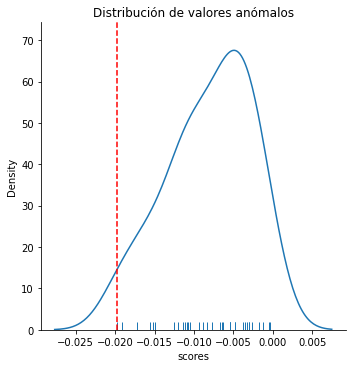

In [5]:
import seaborn as sns
from sklearn.ensemble import IsolationForest

dataset['scores'] = 0

random_state = np.random.RandomState(42)
iforest = IsolationForest(n_estimators=100, contamination= 0.0001, max_samples='auto', max_features=0.8, random_state= random_state)
iforest.fit(dataset.values)

dataset['scores'] = iforest.decision_function(dataset.values)
dataset['anomaly_scores'] = iforest.predict(dataset.values)
anomaly_scores = dataset[dataset['anomaly_scores'] == -1]

umbral = np.quantile(anomaly_scores['scores'], q = 0.0001)
sns.displot(data = anomaly_scores, x='scores', kind = 'kde', rug = True)
plt.axvline(umbral, c='red', linestyle='--', label='umbral')
plt.title('Distribución de valores anómalos')



<AxesSubplot:xlabel='anomaly_scores', ylabel='scores'>

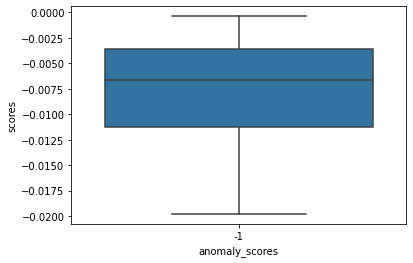

In [6]:
sns.boxplot(x = 'anomaly_scores', y='scores', data= anomaly_scores, palette= 'tab10')

In [7]:
dataset = dataset[dataset['scores']>=umbral]

In [8]:
dataset.to_csv('dataset_limpio.csv')

In [33]:
KMeans().get_params().keys()

dict_keys(['algorithm', 'copy_x', 'init', 'max_iter', 'n_clusters', 'n_init', 'random_state', 'tol', 'verbose'])

In [37]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, make_scorer


def silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels, metric='euclidean')
    return score
scorer = make_scorer(silhouette_score)

In [9]:
# X = dataset.iloc[:,:-1]
# y = dataset.iloc[:,-1]

In [38]:
kf = KFold(n_splits=5, shuffle=True,random_state=1)
for train_index, test_index in kf.split(dataset):
    X_train,X_test = dataset.iloc[train_index,:], dataset.iloc[test_index,:]
#     y_train,y_test = y.iloc[train_index], y.iloc[test_index]

In [52]:
X_test

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Dst_Port_0-1023,Dst_Port_1024-49151,Dst_Port_49152-65535,Protocol_6,Protocol_17,hora_sin,hora_cos,Weekend,scores,anomaly_scores
0,269709,4,5,48.0,23.0,30,0,12.0,14.696938,23,...,0,1,0,1,0,0.965926,0.258819,0,0.333286,1
5,4047,2,2,0.0,0.0,0,0,0.0,0.000000,0,...,0,1,0,1,0,0.258819,0.965926,0,0.346808,1
7,9436,4,4,30.0,30.0,30,0,7.5,15.000000,30,...,0,1,0,1,0,0.258819,0.965926,0,0.342957,1
26,3281,2,2,0.0,0.0,0,0,0.0,0.000000,0,...,0,1,0,1,0,0.258819,0.965926,0,0.347360,1
27,7026,4,4,30.0,30.0,30,0,7.5,15.000000,30,...,0,1,0,1,0,0.258819,0.965926,0,0.344128,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343875,8367,2,5,664.0,1804.0,664,0,332.0,469.518903,1804,...,1,0,0,1,0,-0.965926,-0.258819,0,0.314628,1
343882,105,1,1,0.0,0.0,0,0,0.0,0.000000,0,...,1,0,0,1,0,-0.965926,-0.258819,0,0.369580,1
343883,7653,2,5,635.0,1772.0,635,0,317.5,449.012806,1772,...,1,0,0,1,0,-0.965926,-0.258819,0,0.318083,1
343884,296,1,1,0.0,0.0,0,0,0.0,0.000000,0,...,1,0,0,1,0,-0.965926,-0.258819,0,0.373356,1


In [55]:
scaler = StandardScaler()
kmeans = KMeans(init= 'random', n_clusters = 2)
pipe = Pipeline([("scaler", scaler), ("kmeans", kmeans)])
pipe2 = Pipeline([("kmeans", kmeans)])
params_grid = {'kmeans__n_clusters': [2, 3, 4, 5]}

In [63]:
from sklearnex  import  patch_sklearn 
patch_sklearn ()

kmeans.fit_predict(X_train)
kmeans.score(X_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


-4.034169249385329e+19

In [60]:
from sklearnex  import  patch_sklearn 
patch_sklearn ()

grid = GridSearchCV(estimator=pipe2, param_grid=params_grid, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=1), scoring=scorer)
grid.fit(X_train)
grid.best_estimator_
grid.score(X_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\Lucho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'fit_predict'

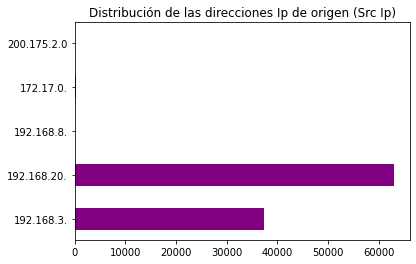

In [11]:
Ip_192_168_3 = dataset['Src-192.168.3.'][dataset['Src-192.168.3.'] == 1].count()
Ip_192_168_20 = dataset['Src-192.168.20.'][dataset['Src-192.168.20.'] == 1].count()
Ip_192_168_8 = dataset['Src-192.168.8.'][dataset['Src-192.168.8.'] == 1].count()
Ip_172_17_0 = dataset['Src-172.17.0.'][dataset['Src-172.17.0.'] == 1].count()
Ip_200_175_2_0 = dataset['Src-200.175.2.0'][dataset['Src-200.175.2.0'] == 1].count()

x = ['192.168.3.', '192.168.20.', '192.168.8.', '172.17.0.', '200.175.2.0' ]
Src_IPs = [Ip_192_168_3, Ip_192_168_20, Ip_192_168_8, Ip_172_17_0, Ip_200_175_2_0]

plt.barh(x, Src_IPs, height = 0.5, color='purple')
plt.title('Distribución de las direcciones Ip de origen (Src Ip)')
plt.show()

(0.0, 170.0)

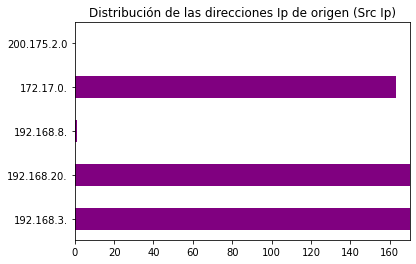

In [10]:
plt.barh(x, Src_IPs, height = 0.5, color='purple')
plt.title('Distribución de las direcciones Ip de origen (Src Ip)')
plt.xlim(0,170)

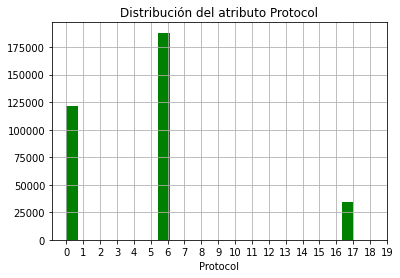

In [7]:
dataset = dataset[['Src Port', 'Dst Port', 'Protocol']]
dataset['Protocol'].hist(bins = 25, color= "green")
plt.title('Distribución del atributo Protocol')
plt.xlabel('Protocol')
plt.xticks(np.arange(20))
plt.show()

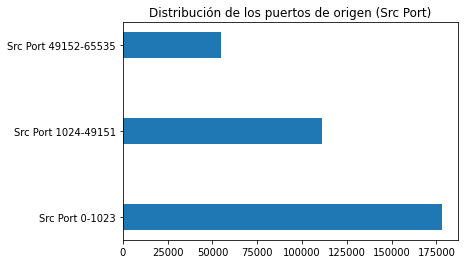

In [6]:
Port_0_1023 = dataset['Src Port 0-1023'][dataset['Src Port 0-1023'] == 1].count()
Port_1024_49151 = dataset['Src Port 1024-49151'][dataset['Src Port 1024-49151'] == 1].count()
Port_49152_65535 = dataset['Src Port 49152-65535'][dataset['Src Port 49152-65535'] == 1].count()
Puertos = [Port_0_1023, Port_1024_49151, Port_49152_65535]
x = ['Src Port 0-1023', 'Src Port 1024-49151', 'Src Port 49152-65535']
plt.barh(x, Puertos, height = 0.3)
plt.title('Distribución de los puertos de origen (Src Port)')
plt.show()

In [92]:
valores_ausentes = dataset.isna().sum().sort_values()
print(valores_ausentes)

Trafico             0
Fwd Seg Size Avg    0
Pkt Size Avg        0
Down/Up Ratio       0
ECE Flag Cnt        0
                   ..
Flow IAT Std        0
Flow IAT Mean       0
Flow Pkts/s         0
Fwd IAT Max         0
Label               0
Length: 86, dtype: int64


In [2]:
dataset = dataset[['Trafico','Src Port','Protocol','Fwd Pkt Len Min','Fwd Pkt Len Mean','Fwd Pkt Len Max','Bwd Pkt Len Min','Bwd Pkt Len Mean','Bwd Pkt Len Max','Bwd Pkt Len Std', 'Pkt Len Min', 'Pkt Len Mean','Pkt Len Max','Pkt Len Std','Pkt Size Avg'
                   , 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Std', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Flow Pkts/s', 'Bwd Pkts/s']]
dataset

,Trafico,Src Port,Protocol,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Std,...,Pkt Size Avg,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Max,Fwd IAT Std,Down/Up Ratio,Fwd Seg Size Avg,Bwd Seg Size Avg,Flow Pkts/s,Bwd Pkts/s
0,1,38694.0,6.0,0.0,12.0,30.0,0.0,4.600000,23.0,10.285913,...,7.888889,260808.0,86936.0,259973.0,149854.765700,1.0,12.0,4.600000,33.369298,18.538499
1,1,38693.0,6.0,0.0,0.0,0.0,0.0,7.666667,23.0,13.279056,...,4.600000,265811.0,265811.0,265811.0,0.000000,1.0,0.0,7.666667,18.615110,11.169066
2,1,33747.0,6.0,0.0,10.6,30.0,0.0,6.000000,30.0,13.416408,...,8.300000,17518.0,4379.5,13537.0,6184.320254,1.0,10.6,6.000000,450.572227,225.286113
3,1,38745.0,6.0,0.0,7.5,30.0,0.0,7.500000,30.0,15.000000,...,7.500000,5511.0,1837.0,3380.0,1441.824885,1.0,7.5,7.500000,837.170364,418.585182
4,1,37217.0,6.0,0.0,7.5,30.0,0.0,7.500000,30.0,15.000000,...,7.500000,4725.0,1575.0,4204.0,2277.042160,1.0,7.5,7.500000,910.954225,455.477112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343884,1,55440.0,6.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,6756.756757,3378.378378
343885,1,55446.0,6.0,0.0,316.5,633.0,0.0,354.600000,1773.0,792.909705,...,343.714286,99.0,99.0,99.0,0.000000,2.0,316.5,354.600000,2040.221510,1457.301078
343886,1,55446.0,6.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,485.319097,242.659549
343887,1,55456.0,6.0,0.0,335.5,671.0,0.0,357.800000,1789.0,800.065122,...,351.428571,173.0,173.0,173.0,0.000000,2.0,335.5,357.800000,1189.060642,849.329030
